In [3]:
# Import a Kalman filter and other libraries

from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (10,7)

C:\Users\Win10\AppData\Local\Temp\ipykernel_23232\1782032133.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


#### **Read the data**

4 year (Aug 2015 - Aug 2019) Adjusted Close price data for Bajaj Auto Limited (BAJAJ-AUTO.NS) and Hero MotoCorp Limited (HEROMOTOCO.NS) is considered


  

In [4]:
# Define path where data file is saved in your system
#path = '../data/'
data = pd.read_csv('data.csv', index_col ='Date')
data['ratio'] = data['BAJAJ']/ data['HERO']
stock_1 = data['BAJAJ']
stock_2 = data['HERO']

# Calculate the hedge ratio for pairs trading
ratio =stock_1/stock_2
data.head()

,BAJAJ,HERO,ratio
Date,,,
8/6/2015,2262.835938,2243.790527,1.008488
8/7/2015,2226.897217,2252.889160,0.988463
8/10/2015,2241.992432,2288.520996,0.979669
8/11/2015,2229.091309,2275.359619,0.979665
8/12/2015,2160.899414,2229.994629,0.969016


#### **Kalman Filter**

Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

Hyperparameters of kalman filter can be changed for say use:

1. Multi dimensional transition matrices, to use more of past information for making predictions at each point
2. Different values of observation and transition covariance




Text(0, 0.5, 'Value')

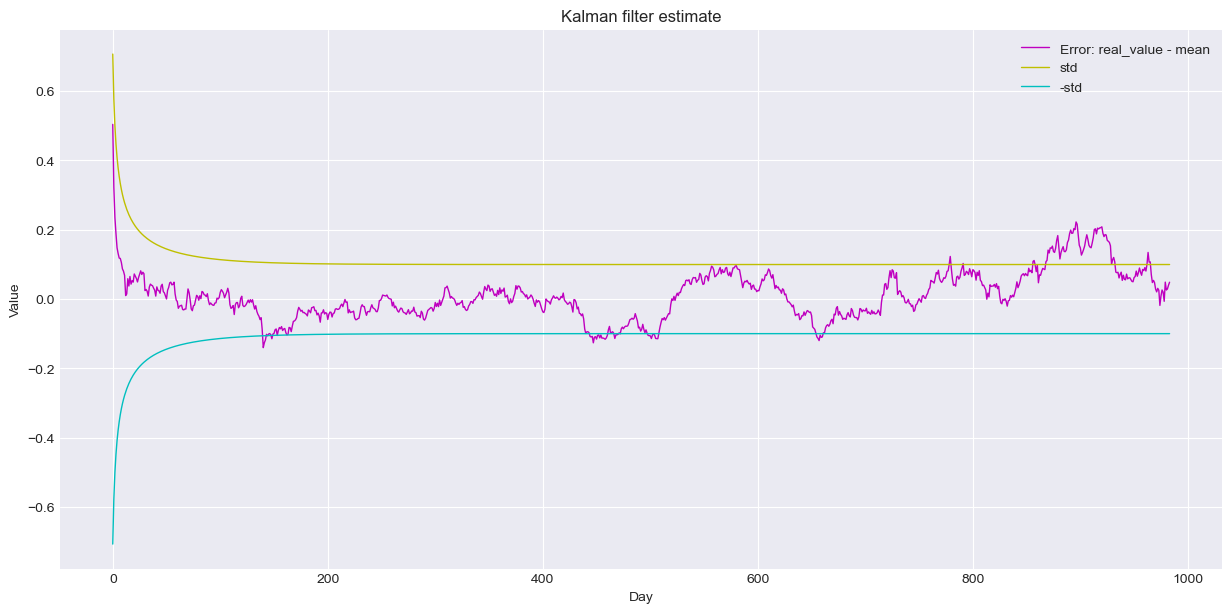

In [5]:
kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

mean, cov = kf.filter(ratio.values)
mean, std = mean.squeeze(), np.std(cov.squeeze())

plt.figure(figsize=(15,7))
plt.plot(ratio.values - mean, 'm', lw=1)
plt.plot(np.sqrt(cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')


#### **Pairs trading strategy**
In pairs trading strategy we buy one stock and sell the other stock choosing the quantity as hedge ratio

In [6]:
# Use the observed values of the price to get a rolling mean and z_score
mean, cov =  kf.filter(ratio.values)
data['mean'] = mean.squeeze()
data['cov'] = cov.squeeze()
data['std'] = np.sqrt(data['cov'])
data = data.dropna()


In [7]:
data['ma'] = data['ratio'].rolling(5).mean()
data['z_score'] = (data['ma'] - data['mean'])/data['std']

In [8]:
# Initialise positions as zero
data['position_1'] = np.nan
data['position_2'] = np.nan

In [9]:
# Generate buy, sell and square off signals as: z<-1 buy, z>1 sell and -1<z<1 liquidate the position
for i in range (data.shape[0]):
  if data['z_score'].iloc[i] < -1:
    data['position_1'].iloc[i] = 1
    data['position_2'].iloc[i] = -round(data['ratio'].iloc[i],0)
  if data['z_score'].iloc[i] > 1:
    data['position_1'].iloc[i] = -1
    data['position_2'].iloc[i] = round(data['ratio'].iloc[i],0)
  if (abs(data['z_score'].iloc[i]) < 1) & (abs(data['z_score'].iloc[i]) > 0):
    data['position_1'].iloc[i] = 0
    data['position_2'].iloc[i] = 0

In [10]:
# Calculate returns
data['returns'] = ((data['BAJAJ']-data['BAJAJ'].shift(1))/data['BAJAJ'].shift(1))*data['position_1'].shift(1)+ ((data['HERO']-data['HERO'].shift(1))/data['HERO'].shift(1))*data['position_2'].shift(1)
data['returns'].sum()

0.12282433836398729